# Libs

In [1]:
import pandas as pd
import sys, os 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

sys.path.append(os.path.abspath(".."))

from scr.utils import (
    normalizar_pais,
    agrupar_pais,
    comprobar_normalidad,
    correlacion_variables,
    comprobar_nomalidad_y_varianza,
    calcular_fuerza_asociacion_2_grupos,
    calcular_fuerza_asociacion_mas_2_grupos,
    cramers_v,
    calcular_independencia_categoricas,
    agrupar_tramo,
    cohens_d,
    r_mannwhitney,
    prueba_comparacion_2grupos_variable
)

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Funcs

In [2]:
#Resumen inicial
def analisis_basico_morosidad(df, col_moroso='Moroso',
                              col_importe='Importe Impagado Actual',
                              col_pct_impagado='% Impagado Actual Vdo',
                              col_cuotas='NUMERO DE CUOTAS'):
    """
    Realiza un análisis básico de morosidad sobre un DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con la información.
    col_moroso : str
        Nombre de la columna que indica si el cliente es moroso (por defecto 'Moroso').
    col_importe : str
        Columna con el importe impagado actual.
    col_pct_impagado : str
        Columna con el % impagado actual vencido.
    col_cuotas : str
        Columna con el número de cuotas.

    Retorna
    -------
    pd.DataFrame
        Resumen con frecuencias, porcentajes y promedios por morosidad.
    """
    
    morosidad_frecuencia = df[col_moroso].value_counts()
    morosidad_porcentaje = df[col_moroso].value_counts(normalize=True) * 100
    
    importe_impagado_promedio = df.groupby(col_moroso)[col_importe].mean()
    porcentaje_impagado_promedio = df.groupby(col_moroso)[col_pct_impagado].mean()
    cuotas_promedio = df.groupby(col_moroso)[col_cuotas].mean()

    resumen = pd.DataFrame({
        'Frecuencia': morosidad_frecuencia,
        '% del total': morosidad_porcentaje,
        'Importe Impagado Promedio': importe_impagado_promedio,
        '% Impagado Promedio': porcentaje_impagado_promedio,
        'Nº Cuotas Promedio': cuotas_promedio
    })
    
    return resumen

#Gráficos
def plot_facturacion(df_convo_deuda, output_path=None):
    """
    Genera un gráfico stacked bar de la composición de la facturación
    pagada e impagada por tramos de % de pago inicial en la inscripción.

    Parámetros
    ----------
    df_convo_deuda : pd.DataFrame
        Debe contener las columnas:
        - '% INSCRIPCION'
        - 'FACTURACIÓN NETA'
        - 'Importe Impagado Actual'
        - 'Importe Cobrado'
    """

    # Copia de trabajo
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato numérico y pasar a %
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'],
                                              errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo
    df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_grouped = df_grouped[(df_grouped.T != 0).any()]

    # Calcular pendiente no vencido
    df_grouped['Pendiente no vencido'] = (
        df_grouped['FACTURACIÓN NETA']
        - df_grouped['Importe Impagado Actual']
        - df_grouped['Importe Cobrado']
    )

    # Calcular % impagado sobre deuda (opcional, útil para análisis extra)
    df_grouped['%II'] = (
        df_grouped['Importe Impagado Actual'] /
        (df_grouped['Importe Impagado Actual'] + df_grouped['Importe Cobrado'])
    ) * 100

    # Preparar datos para gráfico
    df_plot = df_grouped[['Pendiente no vencido',
                          'Importe Impagado Actual', 'Importe Cobrado']]

    # Graficar stacked bar
    ax = df_plot.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 6),
        color=['#1f77b4', "#AF1010", "#19c70d"]
    )

    plt.title('Distribución del impago según el % del pago inicial')
    plt.ylabel('Euros')
    plt.xlabel('% Inscripción')
    plt.legend(
        title='Concepto',
        labels=['Pendiente no vencido', 'Impagado vencido', 'Importe Cobrado']
    )
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df_grouped  # devuelve el dataframe agregado por si quieres usarlo después

def plot_facturacion_prop(df_convo_deuda, output_path=None):
    """
    Genera un gráfico proporcional (100% stacked bar) de la composición de la facturación
    por tramos de % de inscripción y opcionalmente lo guarda como imagen.

    Parámetros
    ----------
    df_convo_deuda : pd.DataFrame
        Debe contener las columnas:
        - '% INSCRIPCION'
        - 'FACTURACIÓN NETA'
        - 'Importe Impagado Actual'
        - 'Importe Cobrado'

    output_path : str, opcional
        Ruta donde guardar la imagen (ej: 'grafico_prop.png').
        Si es None, no guarda nada.
    """

    # Copiar datos
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato numérico (y convertir a %)
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'],
                                              errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo y sumar
    df_plot = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_plot = df_plot[(df_plot.T != 0).any()]

    # Calcular Pte. No Vencido
    df_plot['Pte. No Vencido'] = (
        df_plot['FACTURACIÓN NETA']
        - df_plot['Importe Cobrado']
        - df_plot['Importe Impagado Actual']
    )

    # Evitar negativos por redondeo/incoherencias
    df_plot['Pte. No Vencido'] = df_plot['Pte. No Vencido'].clip(lower=0)

    # Preparar datos en orden (Cobrado, Impagado, Pte. No Vencido)
    df_plot_final = df_plot[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

    # Normalizar a proporción (cada fila suma 1)
    df_plot_prop = df_plot_final.div(df_plot_final.sum(axis=1), axis=0)

    # Graficar
    ax = df_plot_prop.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 6),
        color=['#2ca02c', '#ff7f0e', '#1f77b4']
    )

    plt.title('Distribución proporcional: Facturación vs Impagado por % de Inscripción')
    plt.ylabel('Proporción')
    plt.xlabel('% Inscripción')
    plt.legend(title='Concepto', labels=['Cobrado', 'Impagado', 'Pte. No Vencido'], loc='upper right')
    plt.tight_layout()

    # Guardar si se pasa ruta
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df_plot_prop

def agrupar_tramo(tramo):
    """Agrypa en 4 tramos los distintos
    % de Pago Inicial (PI)"""
    if tramo < 14:
        return '0-13%'
    elif 14 <= tramo < 16:
        return '14-15%'
    elif 16 <= tramo <= 20:
        return '16-20%'
    else:
        return 'Resto'
    
def agrupar_tramo_2(tramo):
    """Agrypa en 4 tramos los distintos
    % de Pago Inicial (PI)"""
    if tramo < 6:
        return '0-5%'
    elif 6 <= tramo < 11:
        return '6-10%'
    elif 11 <= tramo <= 13:
        return '11-13%'
    elif 21 <= tramo <= 30:
        return '21-30%'
    elif 31 <= tramo <= 50:
        return '31-50%'
    else:
        return 'Resto'
    
def plot_facturacion_custom(df_convo_deuda, agrupar_tramo, output_path=None, orden=None):
    """
    Genera un gráfico stacked bar de la facturación agrupada en tramos personalizados
    y añade etiquetas con el % de impagado sobre lo vencido.
    """
    # Copiar datos relevantes
    df_graff = df_convo_deuda[['% INSCRIPCION', 'FACTURACIÓN NETA',
                               'Importe Impagado Actual', 'Importe Cobrado']].copy()

    # Asegurar formato correcto
    df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'], errors='coerce') * 100

    # Crear tramos del 1%
    df_graff['TRAMO % INSCRIPCION'] = pd.cut(
        df_graff['% INSCRIPCION'],
        bins=range(0, 102, 1),
        right=False,
        labels=[f"{i}%" for i in range(0, 101)]
    )

    # Agrupar por tramo y sumar
    df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Eliminar tramos sin datos
    df_grouped = df_grouped[(df_grouped.T != 0).any()]

    # Copia para agrupar en bloques personalizados
    df_grouped_custom = df_grouped.copy()
    df_grouped_custom['tramo_numerico'] = df_grouped_custom.index.str.replace('%', '').astype(int)
    df_grouped_custom['GRUPO PERSONALIZADO'] = df_grouped_custom['tramo_numerico'].apply(agrupar_tramo)
    df_grouped_custom.drop(columns=['tramo_numerico'], inplace=True)

    # Agrupar por grupo personalizado
    df2 = df_grouped_custom.groupby('GRUPO PERSONALIZADO')[
        ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
    ].sum()

    # Calcular Pte. No Vencido
    df2['Pte. No Vencido'] = df2['FACTURACIÓN NETA'] - df2['Importe Impagado Actual'] - df2['Importe Cobrado']
    df2['Pte. No Vencido'] = df2['Pte. No Vencido'].clip(lower=0)

    # Calcular % impagado sobre lo vencido
    df2['% Impagado VDO'] = df2['Importe Impagado Actual'] / (df2['Importe Impagado Actual'] + df2['Importe Cobrado'])
    df2['% Impagado VDO'] = df2['% Impagado VDO'].fillna(0)
    df2['% Impagado VDO Texto'] = (df2['% Impagado VDO'] * 100).round(1).astype(str) + '%'

    # Preparar datos para gráfico
    df_plot = df2[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

    # Si no se pasa orden, usar el índice actual
    if orden is None:
        orden = df2.index.tolist()

    # Reordenar si las etiquetas están en el índice
    orden_validado = [g for g in orden if g in df2.index]
    df_plot = df_plot.loc[orden_validado]
    df2 = df2.loc[orden_validado]

    # Graficar
    ax = df_plot.plot(kind='bar', stacked=True, figsize=(14, 6),
                      color=['#19c70d', '#AF1010', '#1f77b4'])

    # Añadir etiquetas con % impagado centradas en la franja naranja
    for i, val in enumerate(df2['% Impagado VDO Texto']):
        base = df_plot.iloc[i, 0]
        altura = df_plot.iloc[i, 1]
        y = base + altura / 2
        ax.text(i, y, val,
                ha='center', va='center', fontsize=10, fontweight='bold', color="black")

    plt.title('Composición interna de la facturación y % Impagado sobre vencido')
    plt.ylabel('Euros')
    plt.xlabel('Grupo % Inscripción')
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gráfico guardado en {output_path}")

    plt.show()

    return df2

def analizar_categoricas_vs_objetivo(df, target_col, alpha=0.05, verbose=True, plot=True, output_path = None):
    """
    Analiza la relación entre variables categóricas y una variable objetivo categórica
    usando Chi2 y Cramér's V, y genera un heatmap con los resultados significativos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con variables categóricas y la variable objetivo.
    target_col : str
        Nombre de la variable objetivo categórica (ej. 'Moroso').
    alpha : float, opcional (default=0.05)
        Nivel de significación para considerar una variable como significativa.
    verbose : bool, opcional
        Si True, imprime un resumen en pantalla.
    plot : bool, opcional
        Si True, genera un heatmap con los valores de Cramér's V.

    Retorna
    -------
    df_resultados : pd.DataFrame
        DataFrame con columnas:
        ['var1', 'var2', 'chi2', 'p', 'V']
        ordenado por fuerza de asociación (V).
    """

    # Seleccionar solo variables categóricas
    df_categoricas = df.select_dtypes(include='category')

    # Excluir la columna target si está
    if target_col in df_categoricas.columns:
        df_categoricas = df_categoricas.drop(columns=target_col)

    # Calcular relaciones
    list_corr_cat = []
    for cat in df_categoricas.columns:
        var1, var2, chi2, p, V = calcular_independencia_categoricas(df, cat, target_col)
        list_corr_cat.append([var1, var2, chi2, p, V])

    # Construir DataFrame de resultados
    df_correlacion_cat = pd.DataFrame(list_corr_cat, columns=['var1', 'var2', 'chi2', 'p', 'V'])

    # Filtrar significativas
    df_significativas = df_correlacion_cat[df_correlacion_cat['p'] < alpha].sort_values('V', ascending=False)

    if verbose:
        print('*' * 100)
        print(f"{len(df_significativas)} de las {len(df_correlacion_cat)} variables categóricas "
              f"son significativas para {target_col} (α={alpha})")
        print("Ordenadas según su fuerza de asociación por el estadístico V de Cramer:")
        display(df_significativas)

    # Heatmap de las significativas
    if plot and not df_significativas.empty:
        plt.figure(figsize=(8, max(4, len(df_significativas) * 0.5)))
        sns.heatmap(df_significativas.set_index("var1")[["V"]],
                    annot=True, cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
        plt.title(f"Asociación de variables categóricas con {target_col} (Cramér's V)")
        plt.tight_layout()
        plt.show()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✅ Gráficos guardados en {output_path}")
    return df_correlacion_cat

def analizar_numericas_vs_objetivo(df, target_col, alpha=0.05, verbose=True, plot=True, output_path = None):
    """
    Analiza la relación entre variables numéricas y una variable objetivo categórica (binaria),
    aplicando tests de comparación (t-test o Mann-Whitney) y calculando tamaño del efecto.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con variables numéricas y la variable objetivo.
    target_col : str
        Nombre de la variable objetivo categórica (ej. 'Moroso').
    alpha : float, opcional (default=0.05)
        Nivel de significación.
    verbose : bool, opcional
        Si True, imprime un resumen en pantalla.
    plot : bool, opcional
        Si True, genera un heatmap ordenado por tamaño del efecto.

    Retorna
    -------
    df_resultados : pd.DataFrame
        DataFrame con columnas:
        ['col', 'p Shapiro-Wilk', 'p Levene', 'metodo', 'stat', 'p_test', 'effect_size']
    """

    df_num = df.select_dtypes(include="number")

    list_corr_num = []
    for col in df_num.columns:
        try:
            p_norm, p_var, metodo, stat, p_test, effect_size = prueba_comparacion_2grupos_variable(
                df_num[col], df[target_col]
            )
            list_corr_num.append([col, p_norm, p_var, metodo, stat, p_test, effect_size])
        except Exception as e:
            print(f"⚠️ Error con la variable {col}: {e}")

    df_correlacion_num = pd.DataFrame(
        list_corr_num,
        columns=['col', 'p Shapiro-Wilk', 'p Levene', 'metodo', 'stat', 'p_test', 'effect_size']
    )

    # Filtrar significativas
    df_significativas = df_correlacion_num[df_correlacion_num['p_test'] < alpha].copy()

    # Ordenar por tamaño del efecto (valor absoluto, mayor impacto primero)
    df_significativas = df_significativas.reindex(
        df_significativas['effect_size'].abs().sort_values(ascending=False).index
    )

    if verbose:
        print('*' * 100)
        print(f"{len(df_significativas)} de las {len(df_correlacion_num)} variables numéricas "
              f"son significativas para {target_col} (α={alpha})")
        print("Ordenadas por tamaño del efecto:")
        display(df_significativas)

    # Heatmap de las significativas
    if plot and not df_significativas.empty:
        plt.figure(figsize=(8, max(4, len(df_significativas) * 0.5)))
        sns.heatmap(df_significativas.set_index("col")[["effect_size"]],
                    annot=True, cmap="RdBu_r", center=0, cbar=True, vmin=-1, vmax=1)
        plt.title(f"Tamaño del efecto de variables numéricas frente a {target_col}")
        plt.tight_layout()
        plt.show()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✅ Gráficos guardados en {output_path}")

    return df_correlacion_num

def boxplots_numericas_vs_objetivo(df, target_col, output_path=None, max_cols=3,
                                   width=4, height=3):
    """
    Genera boxplots de todas las variables numéricas frente a una variable categórica (ej. Moroso).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    target_col : str
        Variable categórica objetivo (ej. 'Moroso').
    output_path : str, opcional
        Ruta donde guardar la imagen completa (ej. 'boxplots.png'). Si None, no guarda.
    max_cols : int, opcional
        Número máximo de columnas en la cuadrícula de subplots.
    width : int, opcional
        Ancho de cada subplot en pulgadas (default=4).
    height : int, opcional
        Alto de cada subplot en pulgadas (default=3).

    Retorna
    -------
    None
    """

    # Seleccionar variables numéricas
    num_cols = df.select_dtypes(include="number").columns.tolist()

    if not num_cols:
        print("⚠️ No se encontraron variables numéricas en el DataFrame.")
        return

    # Definir grid de subplots
    n_vars = len(num_cols)
    n_cols = min(max_cols, n_vars)
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))
    axes = axes.flatten() if n_vars > 1 else [axes]

    # Crear cada boxplot
    for i, col in enumerate(num_cols):
        sns.boxplot(x=target_col, y=col, data=df.reset_index(), ax=axes[i])
        axes[i].set_title(f"{col}", fontsize=10)
        axes[i].set_xlabel(target_col, fontsize=8)
        axes[i].set_ylabel(col, fontsize=8)

    # Eliminar ejes vacíos si sobran
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    # Guardar si se pide
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"✅ Gráficos guardados en {output_path}")

    plt.show()


# Paths

In [3]:
path_processed_data = os.path.join('..', 'data','processed')
path_reports = os.path.join('..', 'reports')

# Load

In [4]:
df_convo_deuda = pd.read_csv(os.path.join(path_processed_data, 'data.csv'))

# Transform

In [5]:
# Convertir las variables pertientes a categoricas
columnas_categoricas = ['DIA CERO', 'ID PROGRAMA',
       'TIPO PROGRAMA', 'NACIONALIDAD', 'PAÍS DE RESIDENCIA', 
       'MEDIO PAGO PI', 'MEDIO PAGO IMPORTE PENDIENTE', 
       'DIFERENCIA PI vs. IMPORTE PTE',
       'FORMA DE PAGO', 'ASESOR', 'Moroso',
       'FORMA DE PAGO ORIGINAL', 'AGRUPACION NACIONALIDAD', 
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA PI vs. IMPORTE PTE'
         ]
for col in columnas_categoricas:
    df_convo_deuda[col] = df_convo_deuda[col].astype('category')

# EDA

## Vista preliminar

In [6]:
df_convo_deuda.head()

,DIA CERO,FECHA PRODUCCIÓN,ID PROGRAMA,PRECIO CURSO,FACTURACIÓN NETA,IMPORTE INSCRIPCIÓN,% INSCRIPCION,MEDIO PAGO PI,IMPORTE PENDIENTE PAGO,MEDIO PAGO IMPORTE PENDIENTE,...,AGRUPACION PAÍS DE RESIDENCIA,MANTIENE MEDIO PAGO,DIFERENCIA PI vs. IMPORTE PTE,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,% DTO,Moroso,% Impagado Actual Vdo,Importe Impagado Actual,Importe Cobrado
0,False,2023-05-23,990,13900.0,7993.89,799.89,0.100063,TARJETA,7194.00,LINK DE PAGO,...,CHILE,False,False,0.0,39.0,0.424900,False,0.000000,0.0,7993.9
1,False,2023-05-31,720,7500.0,4937.62,740.64,0.149999,TARJETA,4196.98,LINK DE PAGO,...,ECUADOR,False,False,0.0,184.0,0.341651,True,0.850008,4197.0,740.6
2,False,2023-05-31,150,7500.0,5343.75,801.56,0.150000,TARJETA,4542.19,TARJETA,...,PERÚ,True,True,0.0,306.0,0.287500,False,0.000000,0.0,5343.6
3,False,2023-07-03,400,7500.0,4809.37,721.41,0.150001,TARJETA,4087.96,TARJETA,...,R. LATAM,True,True,0.0,90.0,0.358751,False,0.000000,0.0,3986.6
4,False,2023-07-17,700,7500.0,5062.50,506.25,0.100000,PAYBAY,4556.25,LINK DE PAGO,...,MÉXICO,False,False,0.0,46.0,0.325000,False,0.000000,0.0,5062.7


In [7]:
df_convo_deuda.columns

Index(['DIA CERO', 'FECHA PRODUCCIÓN', 'ID PROGRAMA', 'PRECIO CURSO',
       'FACTURACIÓN NETA', 'IMPORTE INSCRIPCIÓN', '% INSCRIPCION',
       'MEDIO PAGO PI', 'IMPORTE PENDIENTE PAGO',
       'MEDIO PAGO IMPORTE PENDIENTE', 'NUMERO DE CUOTAS', 'FECHA 1ra CUOTA',
       'FORMA DE PAGO', 'ASESOR', 'FECHA 1ra CUOTA ORIGINAL',
       'FORMA DE PAGO ORIGINAL', 'TIPO PROGRAMA', 'NACIONALIDAD',
       'PAÍS DE RESIDENCIA', 'AGRUPACION NACIONALIDAD',
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA PI vs. IMPORTE PTE',
       'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL',
       'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA', '% DTO', 'Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado'],
      dtype='object')

In [8]:
df_convo_deuda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   DIA CERO                                 2595 non-null   category
 1   FECHA PRODUCCIÓN                         2595 non-null   object  
 2   ID PROGRAMA                              2595 non-null   category
 3   PRECIO CURSO                             2595 non-null   float64 
 4   FACTURACIÓN NETA                         2595 non-null   float64 
 5   IMPORTE INSCRIPCIÓN                      2595 non-null   float64 
 6   % INSCRIPCION                            2595 non-null   float64 
 7   MEDIO PAGO PI                            2595 non-null   category
 8   IMPORTE PENDIENTE PAGO                   2595 non-null   float64 
 9   MEDIO PAGO IMPORTE PENDIENTE             2595 non-null   category
 10  NUMERO DE CUOTAS                    

In [9]:
df_convo_deuda.describe()

,PRECIO CURSO,FACTURACIÓN NETA,IMPORTE INSCRIPCIÓN,% INSCRIPCION,IMPORTE PENDIENTE PAGO,NUMERO DE CUOTAS,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,% DTO,% Impagado Actual Vdo,Importe Impagado Actual,Importe Cobrado
count,2595.000000,2595.00000,2595.000000,2595.000000,2.595000e+03,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,8201.811175,5413.66044,1002.512316,0.188317,4.411148e+03,10.244316,1.695568,62.253565,0.336374,0.088194,450.737495,4611.835029
std,1903.907993,1141.64400,831.012827,0.154078,1.316023e+03,5.569879,15.093151,68.773681,0.052016,0.228454,1245.230764,1770.518387
min,7500.000000,1749.75000,0.000000,0.000000,-9.094947e-13,0.000000,-122.000000,-316.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.000000,4809.37000,730.770000,0.149999,4.052695e+03,5.500000,0.000000,20.000000,0.298900,0.000000,0.000000,4206.150000
50%,7500.000000,5076.56000,800.990000,0.150000,4.285910e+03,12.000000,0.000000,35.000000,0.335000,0.000000,0.000000,4809.400000
75%,7700.000000,5347.33000,1000.425000,0.199999,4.542190e+03,14.000000,0.000000,90.000000,0.374568,0.000000,0.000000,5212.200000
max,13900.000000,13900.00000,9771.700000,1.000000,1.181500e+04,21.000000,214.000000,1140.000000,0.766700,1.000000,11997.300000,13900.100000


In [10]:
df_convo_deuda.columns

Index(['DIA CERO', 'FECHA PRODUCCIÓN', 'ID PROGRAMA', 'PRECIO CURSO',
       'FACTURACIÓN NETA', 'IMPORTE INSCRIPCIÓN', '% INSCRIPCION',
       'MEDIO PAGO PI', 'IMPORTE PENDIENTE PAGO',
       'MEDIO PAGO IMPORTE PENDIENTE', 'NUMERO DE CUOTAS', 'FECHA 1ra CUOTA',
       'FORMA DE PAGO', 'ASESOR', 'FECHA 1ra CUOTA ORIGINAL',
       'FORMA DE PAGO ORIGINAL', 'TIPO PROGRAMA', 'NACIONALIDAD',
       'PAÍS DE RESIDENCIA', 'AGRUPACION NACIONALIDAD',
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA PI vs. IMPORTE PTE',
       'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL',
       'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA', '% DTO', 'Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado'],
      dtype='object')

In [11]:
#Número de observación de cada categoría de la variable de interés.
df_convo_deuda['Moroso'].value_counts()

Moroso
False    2104
True      491
Name: count, dtype: int64

In [12]:
porcentaje_moroso = len(
    df_convo_deuda[df_convo_deuda['Moroso']==True]
    )/len(
        df_convo_deuda)*100
print (f'El porcentaje de morosidad de la muestra es del {round(porcentaje_moroso, 1)}%.')
porcentaje_impago = round(
    df_convo_deuda['Importe Impagado Actual'].sum()
    /(df_convo_deuda['Importe Impagado Actual'].sum()
      + df_convo_deuda['Importe Cobrado'].sum())
      *100,
      2)
print (f'''Esto supone que aún no se han cobrado {round(df_convo_deuda['Importe Impagado Actual'].sum(),0)}€ del total que ya debería estar ingresado,
es decir, un {porcentaje_impago}% de los que se debería haber pagado''')

El porcentaje de morosidad de la muestra es del 18.9%.
Esto supone que aún no se han cobrado 1169664.0€ del total que ya debería estar ingresado,
es decir, un 8.9% de los que se debería haber pagado


In [13]:
resumen_morosidad = analisis_basico_morosidad(df_convo_deuda)
resumen_morosidad


,Frecuencia,% del total,Importe Impagado Promedio,% Impagado Promedio,Nº Cuotas Promedio
Moroso,,,,,
False,2104,81.078998,0.000000,0.000000,9.740494
True,491,18.921002,2382.207332,0.466117,12.403259


+ Los morosos presentan una deuda promedio de más de 2.300 € y dejan sin pagar casi la mitad de lo que vencen.

+ Además, suelen estar asociados a contratos con más cuotas, lo que podría reflejar mayor riesgo en préstamos más largos.

## Hipótesis 1: Relación entre el % de Pago inicial (PI) y el importe imagado vencido

✅ Gráfico guardado en ..\reports\01_distribucion_impago_segun_pi.jpg


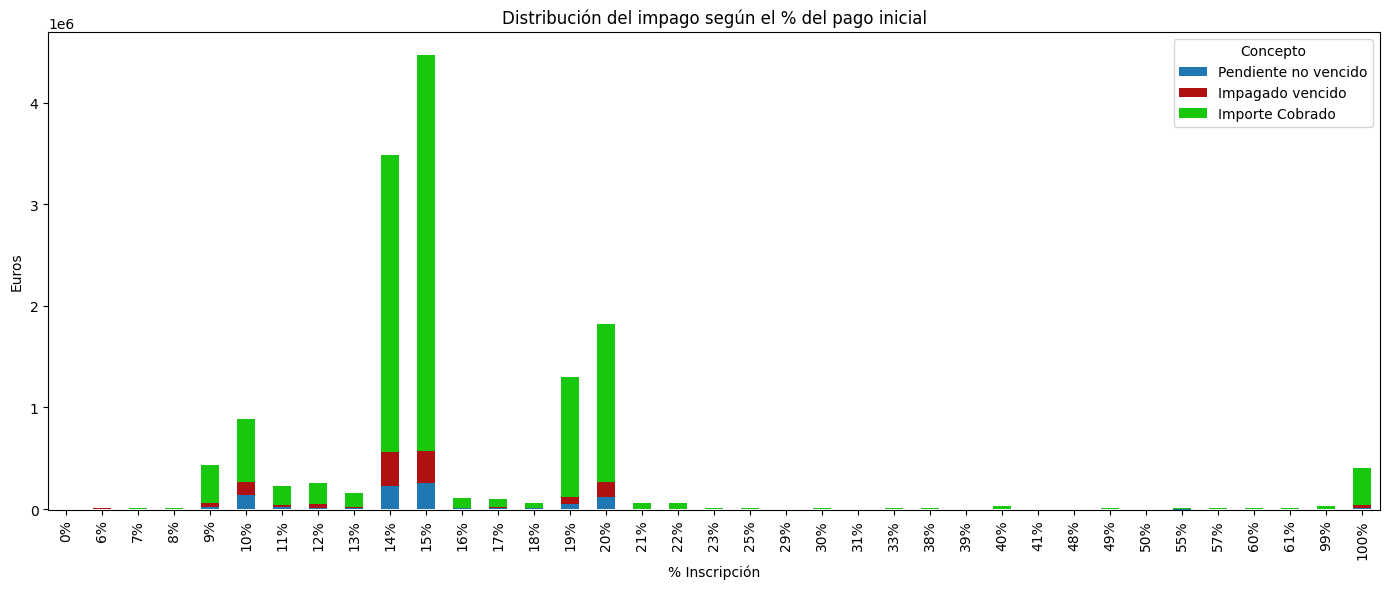

In [14]:
df_result = plot_facturacion(df_convo_deuda, os.path.join(path_reports, '01_distribucion_impago_segun_pi.jpg'))

La mayor parte de la facturación y del riesgo de impago se concentra en inscripciones con pagos iniciales bajos (10%–20%), especialmente en el 13–15%. El importe cobrado domina el gráfico, pero esos tramos también concentran los impagos y pendientes, lo que sugiere que son los segmentos críticos a analizar en profundidad (posible riesgo de clientes con baja entrada inicial).

✅ Gráfico guardado en ..\reports\02_distribucion_impago_segun_pi_100.jpg


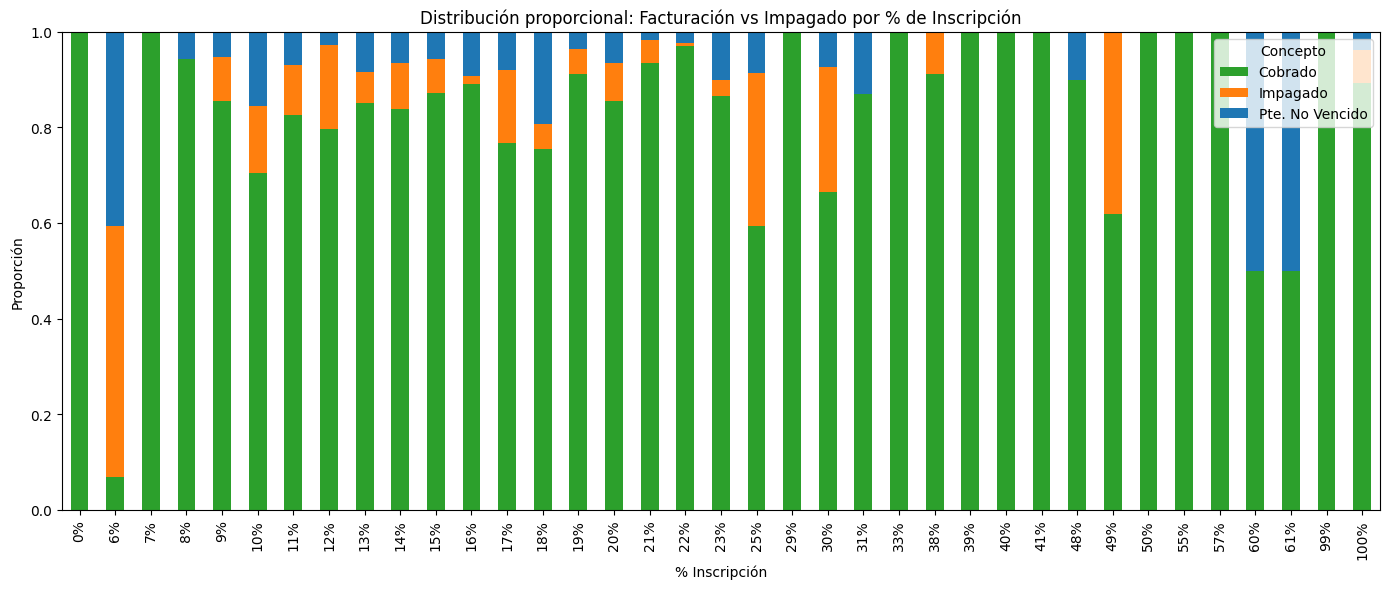

In [15]:
df_result_prop = plot_facturacion_prop(df_convo_deuda, output_path=os.path.join(path_reports, "02_distribucion_impago_segun_pi_100.jpg"))


Normalizando las diferencias de volume, se pone en evidencia que los problemas de impago están focalizados en los tramos de inscripción baja, mientras que los tramos altos muestran casi total seguridad de cobro.

✅ Gráfico guardado en ..\reports\03_distribucion_impago_segun_pi_agrupado.jpg


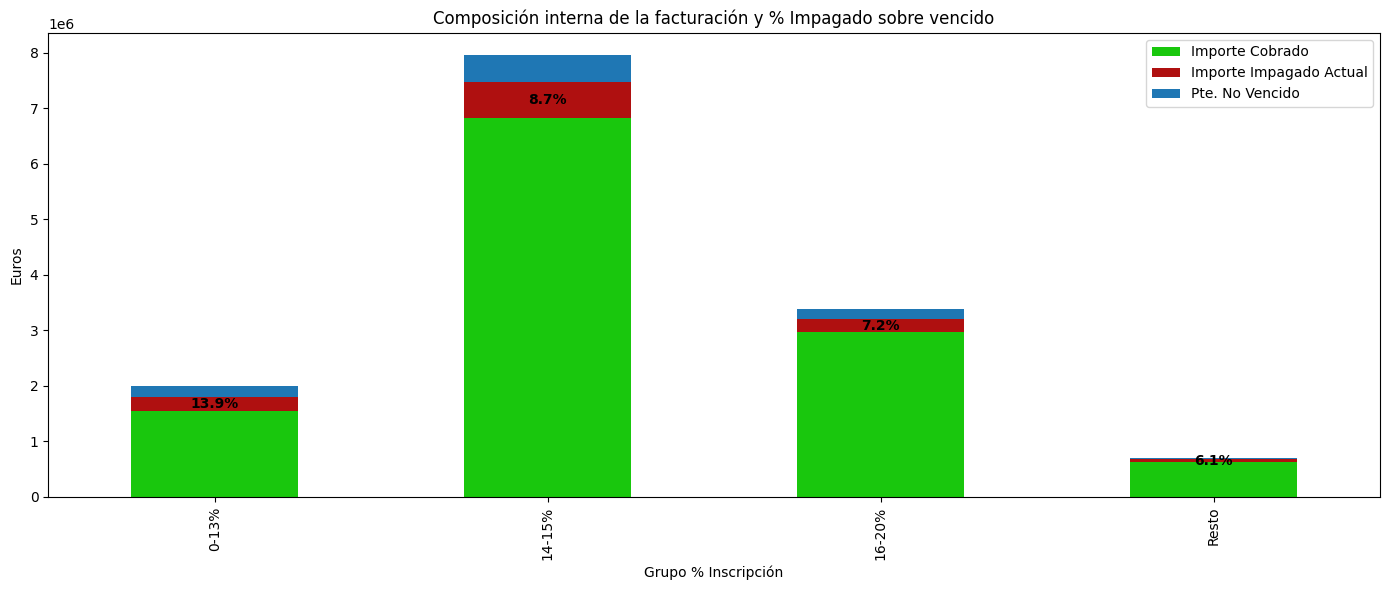

In [16]:
df_result_agg = plot_facturacion_custom(df_convo_deuda,agrupar_tramo, 
                                        output_path=os.path.join(path_reports, "03_distribucion_impago_segun_pi_agrupado.jpg"))

✅ Gráfico guardado en ..\reports\04_distribucion_impago_segun_pi_agrupado_2.jpg


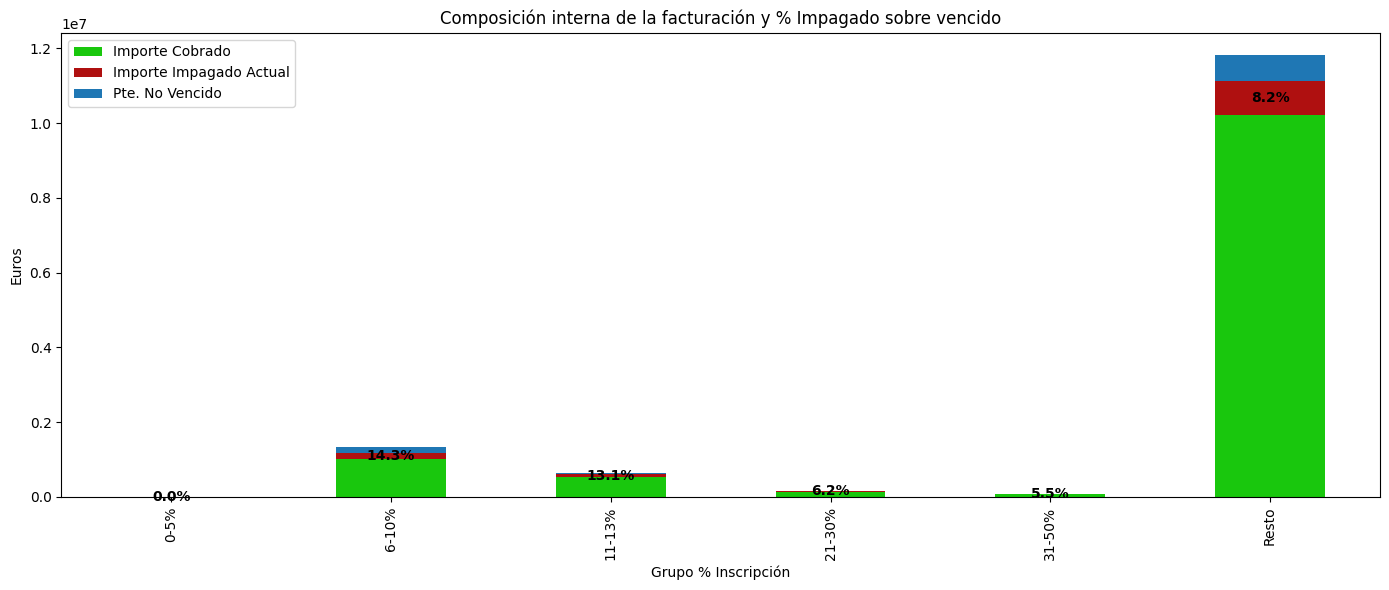

In [17]:
df_result_agg_2 = plot_facturacion_custom(df_convo_deuda,agrupar_tramo_2, 
                                          output_path=os.path.join(path_reports, "04_distribucion_impago_segun_pi_agrupado_2.jpg"),
                                          orden=['0-5%', '6-10%', '11-13%', '21-30%', '31-50%', 'Resto']
                                          )

+ El mayor riesgo relativo está en las inscripciones entre 6% y 13% (donde el impago supera el 13%).

+ El mayor riesgo absoluto en euros está en el grupo Resto (>50%), porque concentra muchísima facturación, aunque con un % de impago más bajo.

+ Los tramos intermedios (21–50%) muestran menor riesgo tanto en importe como en proporción, pero su peso es pequeño en facturación.

## Análisis estadístico

### Relación entre las variables categóricas y la Morosidad

****************************************************************************************************
10 de las 14 variables categóricas son significativas para Moroso (α=0.05)
Ordenadas según su fuerza de asociación por el estadístico V de Cramer:


,var1,var2,chi2,p,V
9,PAÍS DE RESIDENCIA,Moroso,115.306234,2.339521e-05,0.210794
4,FORMA DE PAGO,Moroso,108.554569,2.245876e-23,0.204529
8,NACIONALIDAD,Moroso,91.265457,3.467575e-03,0.187644
6,FORMA DE PAGO ORIGINAL,Moroso,82.827112,2.147988e-16,0.178656
2,MEDIO PAGO PI,Moroso,63.072311,3.415909e-10,0.155902
11,AGRUPACION PAÍS DE RESIDENCIA,Moroso,55.641573,2.395926e-08,0.146430
3,MEDIO PAGO IMPORTE PENDIENTE,Moroso,39.961815,4.407845e-08,0.124095
10,AGRUPACION NACIONALIDAD,Moroso,36.775509,6.188314e-05,0.119114
12,MANTIENE MEDIO PAGO,Moroso,25.745732,3.894875e-07,0.099606
13,DIFERENCIA PI vs. IMPORTE PTE,Moroso,25.745732,3.894875e-07,0.099606


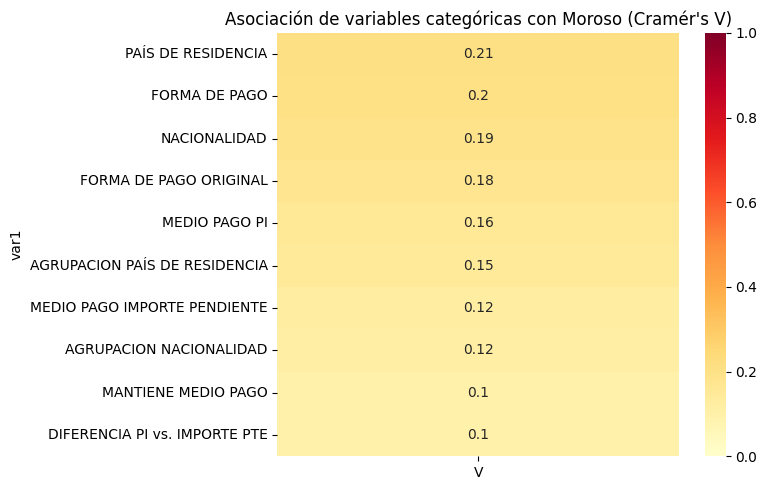

✅ Gráficos guardados en ..\reports\05_correlacion_categoricas_morosidad.jpg


<Figure size 640x480 with 0 Axes>

In [18]:
df_relacion_categoricas = analizar_categoricas_vs_objetivo(
    df_convo_deuda,
      target_col="Moroso",
      output_path=os.path.join(path_reports, "05_correlacion_categoricas_morosidad.jpg"))


### Relación entre las variables numéricas y la Morosidad


📊 Variable: PRECIO CURSO
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.813 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney U → p = 0.365
No se encontraron diferencias significativas entre grupos según Mann-Whitney.

📊 Variable: FACTURACIÓN NETA
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.842 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney U → p = 0.012
Tamaño del efecto (r de Mann-Whitney): 0.049

📊 Variable: IMPORTE INSCRIPCIÓN
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.125 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney U → 

,col,p Shapiro-Wilk,p Levene,metodo,stat,p_test,effect_size
9,Importe Cobrado,3.333695e-15,5.428049e-28,Mann-Whitney,933575.0,2.876853e-171,0.547629
5,NUMERO DE CUOTAS,6.853391e-29,1.916659e-21,Mann-Whitney,410767.0,4.697733e-13,0.138883
7,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,2.273235e-24,1.527183e-06,Mann-Whitney,413809.5,6.319418e-12,0.134887
4,IMPORTE PENDIENTE PAGO,4.503283e-29,3.536211e-01,Mann-Whitney,459324.5,1.296276e-04,0.075121
3,% INSCRIPCION,4.815200e-39,1.661074e-01,Mann-Whitney,566010.0,9.289200e-04,0.064971
1,FACTURACIÓN NETA,3.683034e-30,8.416980e-01,Mann-Whitney,478981.0,1.194947e-02,0.049309
8,% DTO,6.683326e-04,7.131113e-01,Mann-Whitney,553271.5,1.389700e-02,0.048244
6,DIFERENCIA FECHA 1ra CUOTA - ORIGINAL,1.496051e-41,1.016934e-03,Mann-Whitney,506534.0,3.883111e-02,0.013129


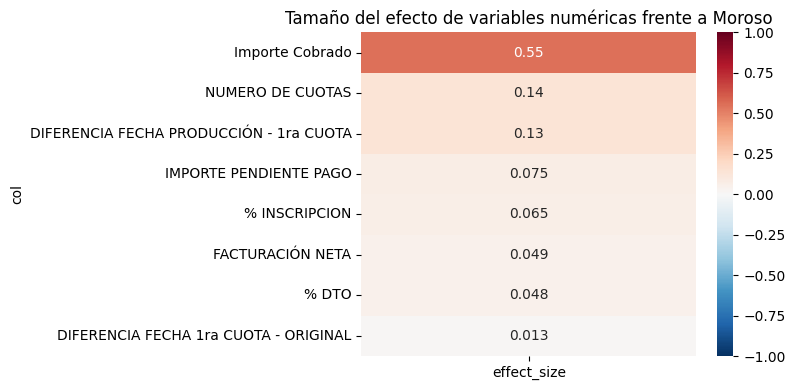

✅ Gráficos guardados en ..\reports\06_correlacion_numericas_morosidad.jpg


<Figure size 640x480 with 0 Axes>

In [19]:
df_relacion_numericas = analizar_numericas_vs_objetivo(
    df_convo_deuda.drop(columns=['% Impagado Actual Vdo', 'Importe Impagado Actual']),
      target_col="Moroso",
      output_path=os.path.join(path_reports, "06_correlacion_numericas_morosidad.jpg"))




### Boxplots

✅ Gráficos guardados en ..\reports\07_boxplots.png


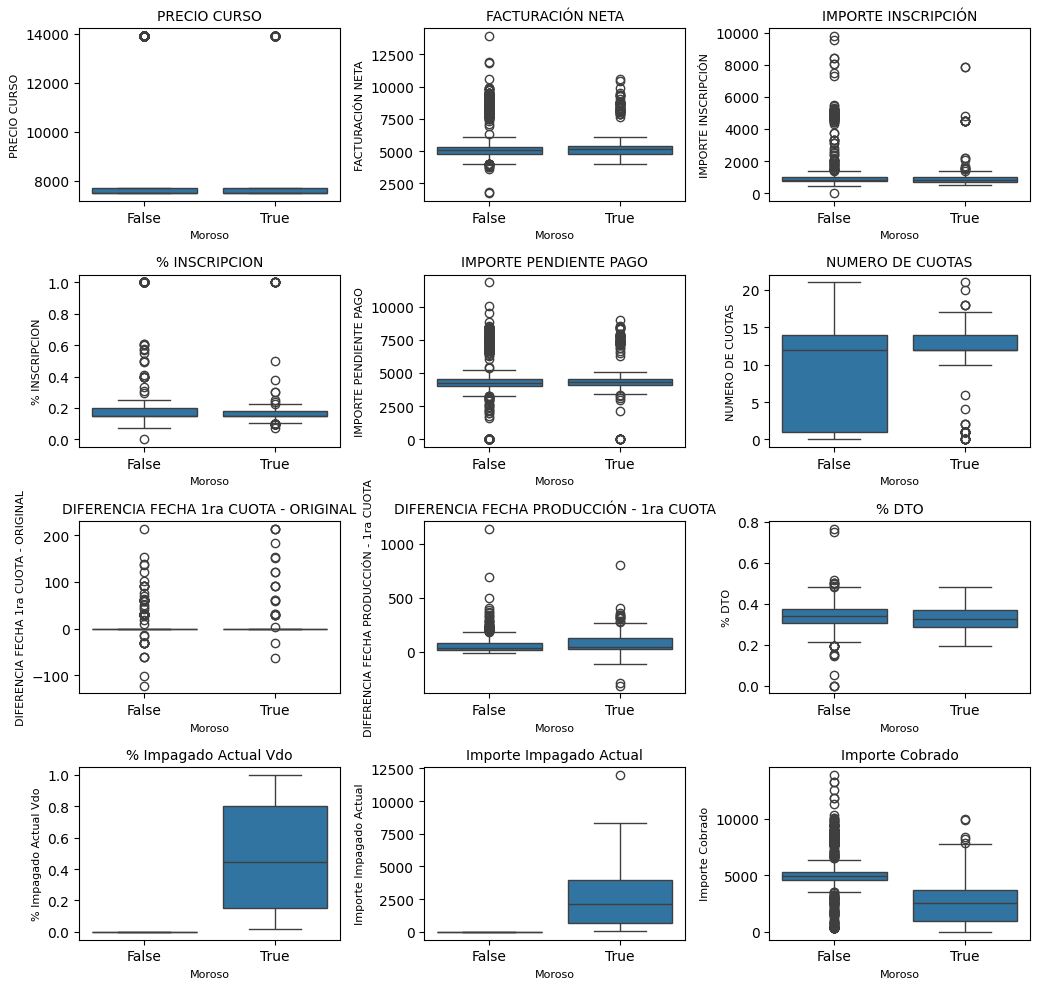

In [20]:
boxplots_numericas_vs_objetivo(
    df_convo_deuda,
    target_col="Moroso",
    output_path= os.path.join(path_reports,"07_boxplots.png"),
    max_cols=3,
    width=3.5,
    height=2.5
)



Variables fuertemente asociadas con la morosidad:
+ Importe pendiente de pago.
+ % Impagado Actual Vdo.
+ Importe impagado actual.
+ Número de cuotas.

Variables con posible relación más débil:
+ % inscripción inicial (morosos pagan menos al inicio).
+ Importe cobrado (más dispersión en morosos).

Variables con poca o nula relación aparente:
+ Precio curso, facturación neta, importe inscripción (similar en ambos grupos).
+ % de descuento y diferencias de fechas.

### Relación de las categorías más influyentes en las variables categóricas

In [30]:
for col in df_relacion_categoricas['var1'].tolist():
    # Convertir 'Moroso' a numérico para calcular la probabilidad
    prob_cat = df_convo_deuda.groupby(col)['Moroso'].apply(lambda x: x.cat.codes.mean()).sort_values(ascending=False)
    tabla = prob_cat.reset_index()
    tabla.columns = [col, 'Probabilidad_Moroso']
    display(tabla)


,DIA CERO,Probabilidad_Moroso
0,False,0.190264
1,True,0.169231


,ID PROGRAMA,Probabilidad_Moroso
0,960,0.333333
1,962,0.285714
2,940,0.273973
3,500,0.272727
4,100,0.264151
5,400,0.238636
6,110,0.236220
7,140,0.230000
8,770,0.221053
9,630,0.203390


,MEDIO PAGO PI,Probabilidad_Moroso
0,TARJETA + TPVF,1.000000
1,TARJETA+TPVF,0.400000
2,TPVF,0.280702
3,PAYCOMET,0.261364
4,0,0.250000
5,TRANSFERENCIA,0.236607
6,PAYBAY,0.231106
7,TARJETA,0.125650
8,BANCO SABADELL,0.000000
9,tarJETA,0.000000


,MEDIO PAGO IMPORTE PENDIENTE,Probabilidad_Moroso
0,LINK DE PAGO,0.243830
1,TARJETA,0.167334
2,SIN IMPORTE PTE,0.144737
3,DOMICILIACION,0.100000
4,TRANSFERENCIA,0.093117


,FORMA DE PAGO,Probabilidad_Moroso
0,APLAZADO,0.234151
1,EFECTIVO,0.130952
2,CONTADO DIAS,0.039711
3,CONTADO 2V,0.000000


,ASESOR,Probabilidad_Moroso
0,Alba De Rosende,1.0
1,Cristobal Horney,1.0
2,Daniela Fazio,1.0
3,patricia angarita,0.5
4,José zegarra,0.5
...,...,...
77,Franklin Morales,0.0
78,Verónica Monje,0.0
79,Xavier Pérez,0.0
80,Xénia Pérez,0.0


,FORMA DE PAGO ORIGINAL,Probabilidad_Moroso
0,APLAZADO,0.229457
1,EFECTIVO,0.134146
2,CONTADO DIAS,0.062609
3,CONTADO,0.000000
4,CONTADO APLAZADO,0.000000
5,CONTADO 2V,0.000000


,TIPO PROGRAMA,Probabilidad_Moroso
0,MBA,0.193050
1,MST,0.188784


,NACIONALIDAD,Probabilidad_Moroso
0,Angola,1.000000
1,Rusia,1.000000
2,Líbano,1.000000
3,Arabia Saudí,0.750000
4,Albania,0.666667
5,Haití,0.500000
6,Bolivia,0.416667
7,Sakartvelo,0.375000
8,India,0.333333
9,Alemania,0.333333


,PAÍS DE RESIDENCIA,Probabilidad_Moroso
0,Angola,1.0
1,China,1.0
2,Costa de Marfil,1.0
3,Catar,1.0
4,Israel,1.0
...,...,...
56,Rumanía,0.0
57,Suiza,0.0
58,Suecia,0.0
59,Túnez,0.0


,AGRUPACION NACIONALIDAD,Probabilidad_Moroso
0,AFR/ASIA,0.279070
1,MÉXICO,0.251381
2,PERÚ,0.244186
3,ECUADOR,0.235075
4,VIP,0.202091
5,R. LATAM,0.199367
6,COLOMBIA,0.162706
7,CHILE,0.160279
8,COSTA RICA,0.142857
9,EUR+US,0.111111


,AGRUPACION PAÍS DE RESIDENCIA,Probabilidad_Moroso
0,AFR/ASIA,0.326087
1,PERÚ,0.263158
2,MÉXICO,0.256000
3,R. LATAM,0.247788
4,ECUADOR,0.244275
5,VIP,0.179245
6,CHILE,0.158385
7,COLOMBIA,0.157390
8,COSTA RICA,0.146067
9,ESPAÑA,0.098039


,MANTIENE MEDIO PAGO,Probabilidad_Moroso
0,False,0.220212
1,True,0.139113


,DIFERENCIA PI vs. IMPORTE PTE,Probabilidad_Moroso
0,False,0.220212
1,True,0.139113
